In [6]:
import pandas as pd

# Load your dataset
file_path = "/kaggle/input/error-annotated-tamil-corpus/Error Annotated Corpus.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Check the first few rows to understand the structure
print(df.head())

# Remove rows with any null values in the dataset
df_cleaned = df.dropna()

# Remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Optionally, you can reset the index after cleaning
df_cleaned = df_cleaned.reset_index(drop=True)

# Check the cleaned dataset
print(df_cleaned.head())

# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv("cleaned_dataset.csv", index=False)


  Error word & consecutive word     Corrected words & its    Annotation
0               10கனநீர் உலைகள்           10கணநீர் உலைகள்  வேற்றெழுத்து
1                   அகளவிரித்து               அகலவிரித்து  வேற்றெழுத்து
2      அணைத்து ஊழியர்களுக்குமான  அனைத்து ஊழியர்களுக்குமான  வேற்றெழுத்து
3               அதள பாதாளதுக்கு         அதல பாதாளத்துக்கு  வேற்றெழுத்து
4           அதற்குறிய தீர்வுகளை       அதற்குரிய தீர்வுகளை  வேற்றெழுத்து
  Error word & consecutive word     Corrected words & its    Annotation
0               10கனநீர் உலைகள்           10கணநீர் உலைகள்  வேற்றெழுத்து
1                   அகளவிரித்து               அகலவிரித்து  வேற்றெழுத்து
2      அணைத்து ஊழியர்களுக்குமான  அனைத்து ஊழியர்களுக்குமான  வேற்றெழுத்து
3               அதள பாதாளதுக்கு         அதல பாதாளத்துக்கு  வேற்றெழுத்து
4           அதற்குறிய தீர்வுகளை       அதற்குரிய தீர்வுகளை  வேற்றெழுத்து


In [7]:
print(df_cleaned.columns)

Index(['Error word & consecutive word', 'Corrected words & its', 'Annotation'], dtype='object')


In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,AutoModel
import pandas as pd

# Load Tamil-specific model and tokenizer
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Load your cleaned dataset
df_cleaned = pd.read_csv("cleaned_dataset.csv")

# Calculate max input and target lengths based on tokenized sentences
max_input_length = max([len(tokenizer.encode(sentence, truncation=True, padding=False)) for sentence in df_cleaned['Error word & consecutive word']])
max_target_length = max([len(tokenizer.encode(sentence, truncation=True, padding=False)) for sentence in df_cleaned['Corrected words & its']])

print(f"Max Input Length: {max_input_length}")
print(f"Max Target Length: {max_target_length}")

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

Max Input Length: 17
Max Target Length: 27


In [9]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [10]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load the cleaned dataset
df_cleaned = pd.read_csv("cleaned_dataset.csv")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df_cleaned, test_size=0.1)

# Convert the dataframe to Hugging Face dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Load NLLB-200 model and tokenizer
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Set the language code for Tamil
tamil_lang_code = "tam_Taml"

# Tokenizer function
def preprocess_function(examples):
    inputs = examples['Error word & consecutive word']
    targets = examples['Corrected words & its']

    # Add language token for Tamil
    inputs = [f"{tamil_lang_code} {text}" for text in inputs]
    
    # Tokenize input and target sequences
    model_inputs = tokenizer(inputs, max_length=17, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=27, truncation=True, padding="max_length")

    # Add the labels to model inputs
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

# Apply tokenization
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    warmup_steps=int(0.1 * len(train_dataset)),
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    run_name="tamil-error-correction-nllb200",
    report_to=[]
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model("trained_model_nllb200")

# Evaluate the model
results = trainer.evaluate(val_dataset)
print(results)


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Map:   0%|          | 0/4510 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-1d6d0c405fd0>:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,7.995195
2,No log,4.742764
3,No log,2.586726
4,6.043500,0.766727
5,6.043500,0.409859


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.w

{'eval_loss': 0.4098591208457947, 'eval_runtime': 11.6067, 'eval_samples_per_second': 43.251, 'eval_steps_per_second': 2.757, 'epoch': 5.0}


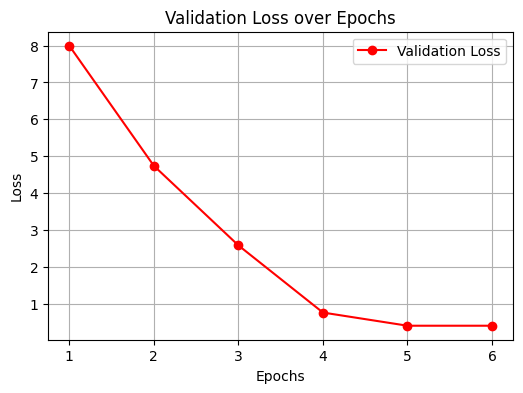

In [11]:
import matplotlib.pyplot as plt

# Extract logs from Trainer state
log_history = trainer.state.log_history

# Separate training and validation losses
train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
learning_rates = [entry['learning_rate'] for entry in log_history if 'learning_rate' in entry]

# Create x-axis for epochs

epochs_eval = range(1, len(eval_losses) + 1)


# Plot validation loss
plt.figure(figsize=(6, 4))
plt.plot(epochs_eval, eval_losses, label="Validation Loss", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

In [12]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu


# Check if GPU is available and move the model to GPU if it is
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Generate predictions on the validation set
predictions = []
references = []

# Use the model to generate predictions on the validation set
for example in val_dataset:
    input_ids = tokenizer(example['Error word & consecutive word'], return_tensors='pt', padding=True, truncation=True, max_length=35).input_ids
    
    # Move input_ids to the correct device (same as the model)
    input_ids = input_ids.to(device)
    
    output_ids = model.generate(input_ids)
    decoded_prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)  # Use tokenizer's decode method

    predictions.append(decoded_prediction)
    references.append(example['Corrected words & its'])

# BLEU Score Calculation (with n-gram overlap)
def calculate_bleu(predictions, references):
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        # Tokenize sentences and calculate BLEU score
        pred_tokens = pred.split()
        ref_tokens = ref.split()
        bleu_scores.append(sentence_bleu([ref_tokens], pred_tokens))  # List of references is passed to sentence_bleu
    return sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0


# Calculate BLEU
bleu_score = calculate_bleu(predictions, references)


# Print the results
print(f"BLEU Score: {bleu_score:.4f}")

BLEU Score: 0.7861


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [13]:
!pip install bert_score
from bert_score import score
P, R, F1 = score(predictions, references, lang="ta")  # Adjust the language if necessary (e.g., "ta" for Tamil)

# Print BERT scores
print(f"BERT Precision: {P.mean():.4f}")
print(f"BERT Recall: {R.mean():.4f}")
print(f"BERT F1 Score: {F1.mean():.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERT Precision: 0.9575
BERT Recall: 0.9582
BERT F1 Score: 0.9578


In [14]:
import nltk

def calculate_ter(references, predictions):
    """
    Compute TER (Translation Edit Rate) score.
    references: list of reference sentences (the correct sentences)
    predictions: list of generated sentences (the sentences predicted by the model)
    """
    # Initialize the TER scores
    ter_scores = []
    
    # Loop over all the sentences
    for ref, hyp in zip(references, predictions):
        ref_tokens = ref.split()  # Tokenize the reference sentence
        hyp_tokens = hyp.split()  # Tokenize the hypothesis sentence

        # Find the minimum edit distance (substitutions, insertions, deletions)
        edits = nltk.edit_distance(ref_tokens, hyp_tokens)

        # TER is calculated as (number of edits + len(reference) - len(hypothesis)) / len(reference)
        ter = (edits + len(ref_tokens) - len(hyp_tokens)) / len(ref_tokens)
        ter_scores.append(ter)

    # Average TER score across all sentences
    avg_ter = sum(ter_scores) / len(ter_scores) if ter_scores else 0
    return avg_ter



ter_score = calculate_ter(references, predictions)
print(f"TER Score: {ter_score:.4f}")

TER Score: 0.3493


In [15]:
import nltk
from collections import Counter

def calculate_gleu(references, predictions, max_order=4):
    """
    Compute GLEU score.
    references: list of reference sentences (the correct sentences)
    predictions: list of generated sentences (the sentences predicted by the model)
    max_order: maximum n-gram length for the BLEU calculation (default is 4)
    """
    def get_ngrams(tokens, n):
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

    def compute_sentence_gleu(ref_tokens, hyp_tokens):
        """
        Compute the GLEU score for a single sentence pair.
        """
        total_ref_ngrams = Counter()
        total_hyp_ngrams = Counter()
        total_match_ngrams = Counter()

        for n in range(1, max_order + 1):
            ref_ngrams = get_ngrams(ref_tokens, n)
            hyp_ngrams = get_ngrams(hyp_tokens, n)
            
            ref_ngrams_count = Counter(ref_ngrams)
            hyp_ngrams_count = Counter(hyp_ngrams)

            total_ref_ngrams.update(ref_ngrams_count)
            total_hyp_ngrams.update(hyp_ngrams_count)
            total_match_ngrams.update(ref_ngrams_count & hyp_ngrams_count)  # Intersection for matching n-grams

        # Compute precision and recall
        precision = sum(total_match_ngrams.values()) / sum(total_hyp_ngrams.values()) if total_hyp_ngrams else 0
        recall = sum(total_match_ngrams.values()) / sum(total_ref_ngrams.values()) if total_ref_ngrams else 0

        # Compute GLEU score (harmonic mean of precision and recall)
        if precision + recall > 0:
            gleu = (1 + 0.5) * (precision * recall) / (0.5 * precision + recall)
        else:
            gleu = 0
        return gleu

    # Initialize the GLEU scores
    gleu_scores = []

    # Loop over all reference-prediction pairs
    for ref, hyp in zip(references, predictions):
        ref_tokens = ref.split()  # Tokenize the reference sentence
        hyp_tokens = hyp.split()  # Tokenize the hypothesis sentence

        gleu_score = compute_sentence_gleu(ref_tokens, hyp_tokens)
        gleu_scores.append(gleu_score)

    # Average GLEU score across all sentences
    avg_gleu = sum(gleu_scores) / len(gleu_scores) if gleu_scores else 0
    return avg_gleu

gleu_score = calculate_gleu(references, predictions)
print(f"GLEU Score: {gleu_score:.4f}")

GLEU Score: 0.5896


In [16]:
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Ensure nltk package is ready
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Tamil samples with similar errors
tamil_samples = [
    # 5-word sentences (5 samples)
    {"incorrect": "வாக்காளர் வழங்கப்பட்டது அரசு அறிவிப்பு", "corrected": "வாக்காளர்களுக்கு வழங்கப்பட்டது அரசு அறிவிப்பு"},
    {"incorrect": "அறிவியல் தொழில்நுட்பம் வளர்ச்சி முக்கியம்", "corrected": "அறிவியல் மற்றும் தொழில்நுட்ப வளர்ச்சி முக்கியம்"},
    {"incorrect": "அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்", "corrected": "அன்புப் பாராட்டு செய்தார் மக்கள் முன்னிலையில்"},
    {"incorrect": "அவசர நடவடிக்க எடுக்க வேண்டும்", "corrected": "அவசர நடவடிக்கை எடுக்க வேண்டும்"},
    {"incorrect": "நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்", "corrected": "நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்"},

    # 4-word sentences (8 samples)
    {"incorrect": "மழை காரணம் வெள்ளம் ஏற்பட்டது", "corrected": "மழை காரணமாக வெள்ளம் ஏற்பட்டது"},
    {"incorrect": "நாடு முன்னேற்ற வளர்ச்சி இன்றியமையாது", "corrected": "நாடு முன்னேற்றம் வளர்ச்சி இன்றியமையாது"},
    {"incorrect": "சுற்றுச்சூழல் பாதுகாப்பு மிக முக்கியம்", "corrected": "சுற்றுச்சூழல் பாதுகாப்பு மிக முக்கியம்"},
    {"incorrect": "அவன் விரைவில் சென்று விட்டான்", "corrected": "அவன் விரைவாக சென்று விட்டான்"},
    {"incorrect": "படிப்பு முடித்த வேலை பெற்றான்", "corrected": "படிப்பு முடித்து வேலை பெற்றான்"},
    {"incorrect": "நேரம் செலவழிக்க மிக முக்கியம்", "corrected": "நேரம் செலவழிக்க மிக முக்கியம்"},
    {"incorrect": "மகிழ்ச்சி உணர்வு மனதை உற்சாகம்", "corrected": "மகிழ்ச்சி உணர்வு மனதை உற்சாகம்"},
    {"incorrect": "மழை காலநிலை கடுமையாக உள்ளது", "corrected": "மழைக்கால நிலை கடுமையாக உள்ளது"},

    # 3-word sentences (2 samples)
    {"incorrect": "நான் பெற்ற மதிப்பெண்", "corrected": "நான் பெற்ற மதிப்பெண்கள்"},
    {"incorrect": "சிறந்த இசை பாடல்", "corrected": "சிறந்த இசைப் பாடல்"},
]

total_bleu_score = 0.0  # Store cumulative BLEU score
num_samples = len(tamil_samples)

for sample in tamil_samples:
    incorrect_sentence = sample["incorrect"]
    corrected_sentence = sample["corrected"]

    # Tokenize the incorrect sentence
    inputs = tokenizer(incorrect_sentence, return_tensors="pt")

    # Move inputs to the same device as the model (GPU if available)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate the predicted sentence
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            max_length=50,
            num_beams=5,  
            temperature=0.7,  
            top_k=50, 
            top_p=0.9,
            early_stopping=True
        )

    # Decode the predicted sentence
    predicted_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Compute BLEU score
    reference = [nltk.word_tokenize(corrected_sentence)]
    candidate = nltk.word_tokenize(predicted_sentence)

    bleu_score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))  # Bi-gram BLEU score
    total_bleu_score += bleu_score

    # Print results
    print("\nIncorrect Sentence:", incorrect_sentence)
    print("Corrected Sentence:", corrected_sentence)
    print("Predicted Sentence:", predicted_sentence)
    print("BLEU Score: {:.2f}".format(bleu_score))

# Compute the average BLEU score
average_bleu_score = total_bleu_score / num_samples
print("\nAverage BLEU Score: {:.2f}".format(average_bleu_score))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



Incorrect Sentence: வாக்காளர் வழங்கப்பட்டது அரசு அறிவிப்பு
Corrected Sentence: வாக்காளர்களுக்கு வழங்கப்பட்டது அரசு அறிவிப்பு
Predicted Sentence: வாக்காளர் வழங்கப்பட்டது அரசு அறிவிப்பு
BLEU Score: 0.71

Incorrect Sentence: அறிவியல் தொழில்நுட்பம் வளர்ச்சி முக்கியம்
Corrected Sentence: அறிவியல் மற்றும் தொழில்நுட்ப வளர்ச்சி முக்கியம்
Predicted Sentence: அறிவியல் தொழில்நுட்பம் வளர்ச்சி முக்கியம்
BLEU Score: 0.39

Incorrect Sentence: அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்
Corrected Sentence: அன்புப் பாராட்டு செய்தார் மக்கள் முன்னிலையில்
Predicted Sentence: அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்
BLEU Score: 0.77

Incorrect Sentence: அவசர நடவடிக்க எடுக்க வேண்டும்
Corrected Sentence: அவசர நடவடிக்கை எடுக்க வேண்டும்
Predicted Sentence: அவசர நடவடிக்கை எடுக்க வேண்டும்
BLEU Score: 1.00

Incorrect Sentence: நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்
Corrected Sentence: நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்
Predicted Sentence: நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்
BLEU Score: 1.00

Incorrect Sen

In [18]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.7 MB/s eta 0:00:00


In [20]:
import torch
import nltk
import sacrebleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu  # Import for GLEU

# Ensure nltk package is ready
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Tamil samples with similar errors
tamil_samples = [
    # 5-word sentences (5 samples)
    {"incorrect": "வாக்காளர் வழங்கப்பட்டது அரசு அறிவிப்பு", "corrected": "வாக்காளர்களுக்கு வழங்கப்பட்டது அரசு அறிவிப்பு"},
    {"incorrect": "அறிவியல் தொழில்நுட்பம் வளர்ச்சி முக்கியம்", "corrected": "அறிவியல் மற்றும் தொழில்நுட்ப வளர்ச்சி முக்கியம்"},
    {"incorrect": "அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்", "corrected": "அன்புப் பாராட்டு செய்தார் மக்கள் முன்னிலையில்"},
    {"incorrect": "அவசர நடவடிக்க எடுக்க வேண்டும்", "corrected": "அவசர நடவடிக்கை எடுக்க வேண்டும்"},
    {"incorrect": "நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்", "corrected": "நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்"},

    # 4-word sentences (8 samples)
    {"incorrect": "மழை காரணம் வெள்ளம் ஏற்பட்டது", "corrected": "மழை காரணமாக வெள்ளம் ஏற்பட்டது"},
    {"incorrect": "நாடு முன்னேற்ற வளர்ச்சி இன்றியமையாது", "corrected": "நாடு முன்னேற்றம் வளர்ச்சி இன்றியமையாது"},
    {"incorrect": "சுற்றுச்சூழல் பாதுகாப்பு மிக முக்கியம்", "corrected": "சுற்றுச்சூழல் பாதுகாப்பு மிக முக்கியம்"},
    {"incorrect": "அவன் விரைவில் சென்று விட்டான்", "corrected": "அவன் விரைவாக சென்று விட்டான்"},
    {"incorrect": "படிப்பு முடித்த வேலை பெற்றான்", "corrected": "படிப்பு முடித்து வேலை பெற்றான்"},
    {"incorrect": "நேரம் செலவழிக்க மிக முக்கியம்", "corrected": "நேரம் செலவழிக்க மிக முக்கியம்"},
    {"incorrect": "மகிழ்ச்சி உணர்வு மனதை உற்சாகம்", "corrected": "மகிழ்ச்சி உணர்வு மனதை உற்சாகம்"},
    {"incorrect": "மழை காலநிலை கடுமையாக உள்ளது", "corrected": "மழைக்கால நிலை கடுமையாக உள்ளது"},

    # 3-word sentences (2 samples)
    {"incorrect": "நான் பெற்ற மதிப்பெண்", "corrected": "நான் பெற்ற மதிப்பெண்கள்"},
    {"incorrect": "சிறந்த இசை பாடல்", "corrected": "சிறந்த இசைப் பாடல்"},
]

total_bleu_score = 0.0
total_gleu_score = 0.0
references = []  # Store references for TER
hypotheses = []  # Store hypotheses for TER

num_samples = len(tamil_samples)

for sample in tamil_samples:
    incorrect_sentence = sample["incorrect"]
    corrected_sentence = sample["corrected"]

    # Tokenize the incorrect sentence
    inputs = tokenizer(incorrect_sentence, return_tensors="pt")

    # Move inputs to the same device as the model (GPU if available)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate the predicted sentence
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            max_length=50,
            num_beams=5,  
            temperature=0.7,  
            top_k=50, 
            top_p=0.9,
            early_stopping=True
        )

    # Decode the predicted sentence
    predicted_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Compute BLEU score
    reference = [nltk.word_tokenize(corrected_sentence)]
    candidate = nltk.word_tokenize(predicted_sentence)
    bleu_score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))  # Bi-gram BLEU score
    total_bleu_score += bleu_score

    # Compute GLEU score (Google BLEU)
    gleu_score = sentence_gleu(reference, candidate)
    total_gleu_score += gleu_score

    # Store sentences for TER calculation
    references.append([corrected_sentence])
    hypotheses.append(predicted_sentence)

    # Print results
    print("\nIncorrect Sentence:", incorrect_sentence)
    print("Corrected Sentence:", corrected_sentence)
    print("Predicted Sentence:", predicted_sentence)
    print("BLEU Score: {:.2f}".format(bleu_score))
    print("GLEU Score: {:.2f}".format(gleu_score))

# Compute the average BLEU and GLEU scores
average_bleu_score = total_bleu_score / num_samples
average_gleu_score = total_gleu_score / num_samples

# Compute TER score
ter_score = sacrebleu.corpus_ter(hypotheses, references).score

print("\nAverage BLEU Score: {:.2f}".format(average_bleu_score))
print("Average GLEU Score: {:.2f}".format(average_gleu_score))
print("TER Score: {:.2f}".format(ter_score))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Incorrect Sentence: வாக்காளர் வழங்கப்பட்டது அரசு அறிவிப்பு
Corrected Sentence: வாக்காளர்களுக்கு வழங்கப்பட்டது அரசு அறிவிப்பு
Predicted Sentence: வாக்காளர் வழங்கப்பட்டது அரசு அறிவிப்பு
BLEU Score: 0.71
GLEU Score: 0.60

Incorrect Sentence: அறிவியல் தொழில்நுட்பம் வளர்ச்சி முக்கியம்
Corrected Sentence: அறிவியல் மற்றும் தொழில்நுட்ப வளர்ச்சி முக்கியம்
Predicted Sentence: அறிவியல் தொழில்நுட்பம் வளர்ச்சி முக்கியம்
BLEU Score: 0.39
GLEU Score: 0.29

Incorrect Sentence: அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்
Corrected Sentence: அன்புப் பாராட்டு செய்தார் மக்கள் முன்னிலையில்
Predicted Sentence: அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்
BLEU Score: 0.77
GLEU Score: 0.71

Incorrect Sentence: அவசர நடவடிக்க எடுக்க வேண்டும்
Corrected Sentence: அவசர நடவடிக்கை எடுக்க வேண்டும்
Predicted Sentence: அவசர நடவடிக்கை எடுக்க வேண்டும்
BLEU Score: 1.00
GLEU Score: 1.00

Incorrect Sentence: ந